In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


class SR_CNN_Model(nn.Module):
    def __init__(self, window_size=64):
        super(SR_CNN_Model, self).__init__()

        # ----- The paper window size w is set to 1440 (KPI), 64 (Yahoo), 30 (Microsoft) ----- #
        self.window_size = window_size 

        # ----- The network is composed of two 1-D convolutional layers (with filter size equals to the sliding window size w) ----- #
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.window_size, kernel_size=self.window_size) 
        self.conv2 = nn.Conv1d(in_channels=self.window_size, out_channels=2 * self.window_size, kernel_size=1)

        # ----- Dense layers ----- #
        # conv1 (kernel=w) -> (batch, w, 1); conv2 (kernel=1) -> (batch, 2w, 1); Flatten -> 2w
        self.fc1 = nn.Linear(2 * self.window_size, 64) # Latent is not mentioned in paper, choose 64
        self.fc2 = nn.Linear(64, 1)

        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

        # SR parameters
        self.amp_window_size = self.window_size # w
        self.series_window_size = self.window_size # w
        self.estimated_points_number = 5 # m=5 (Eq 8, 9)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def _spectral_residual_transform(self, values):

        # ----- Gradient-based Extension ----- #
        n = len(values)
        m = self.estimated_points_number
        if n > m:
            grads = []
            for i in range(1, m + 1):
                g = (values[-1] - values[-m-1+i]) / (m - i + 1)
                grads.append(g)

            avg_g = np.mean(grads) # Eq 8
            ext_point = values[-1] + avg_g * m # Eq 9

            extension = [ext_point] * m
            values_ext = np.concatenate([values, extension])
        else:
            values_ext = values

        # ----- FFT ----- #
        trans = np.fft.fft(values_ext)
        mag = np.abs(trans)
        phase = np.angle(trans)

        # ----- Log Amplitude Spectrum ----- #
        eps = 1e-8
        log_amp = np.log(mag + eps)

        # ----- Moving Average (h_q) ----- #
        q = 3
        if len(log_amp) >= q:
            avg_log_amp = np.convolve(log_amp, np.ones(q)/q, mode='same')
        else:
            avg_log_amp = log_amp

        # ----- Spectral Residual R(f) ----- #
        spectral_residual = log_amp - avg_log_amp

        # ----- Inverse FFT ----- #
        sr_complex = np.exp(spectral_residual + 1j * phase)
        spatial_sr = np.abs(np.fft.ifft(sr_complex))

        # ----- Return only original length ----- #
        return spatial_sr[:n]

    def generate_saliency_map(self, x):
        """
        x : (n_series, window_size)
        """
        # ----- Generate Saliency Map for input x ----- #
        saliency_maps = []
        for i in range(x.shape[0]): # Loop over series (n_series)
            series = x[i, :] # Assuming (window_size, ) for standard single metric monitoring
            sr = self._spectral_residual_transform(series)
            saliency_maps.append(sr)
        return np.array(saliency_maps)

    def _inject_anomaly(self, values, window_idx):
        # ----- randomly select several points in the time series ----- #
        if len(values) < self.window_size:
            return values, 0 # No label

        is_anomaly = 0
        new_values = values.copy()

        # ----- Randomly decide to inject (e.g., 50% chance) ----- #
        if np.random.random() < 0.5:
            is_anomaly = 1
            target_idx = np.random.choice(np.arange(len(values)), np.random.randint(1, 5))

            # ----- Calculate statistics within current sliding window ----- #
            local_window = values
            mean = np.mean(local_window)
            var = np.var(local_window)

            # ------ Local average of preceding z points (z=21) ----- #
            z = 21
            if len(local_window) > z + 1:
                 local_avg = np.mean(local_window[-z-1:-1])
            else:
                 local_avg = mean

            # ----- Inject Anomaly ----- #
            r = np.random.randn()
            injection = (local_avg + mean) * (1 + var) * r + values[target_idx]
            new_values[target_idx] = injection

        return new_values, is_anomaly

    def fit(self, x, n_epochs=10, learning_rate=0.01, batch_size=64):
        """
        x : (n_series, window_size)
        """

        optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        self.train()

        # ----- Prepare Training Data ----- #
        all_series = [x[i, :] for i in range(x.shape[0])] # List of (window_size, ) arrays
        print("Generating training data (Saliency Maps + Anomaly Injection)...")
        X_train = []
        y_train = []
        samples_per_epoch = 10000 # Limit samples

        for _ in range(samples_per_epoch):
            # ----- Randomly pick a series ----- #
            series_idx = np.random.randint(0, len(all_series))
            series = all_series[series_idx]

            if len(series) <= self.window_size:
                continue

            # ----- Random start ----- #
            start_idx = np.random.randint(0, len(series) - self.window_size)
            window_segment = series[start_idx : start_idx + self.window_size]

            # ----- Inject Anomaly (or not) ----- #
            injected_segment, label = self._inject_anomaly(window_segment, 0)

            # ----- Get Saliency Map ----- #
            sr_map = self._spectral_residual_transform(injected_segment)

            X_train.append(sr_map)
            y_train.append(label)

        X_train_tensor = torch.FloatTensor(np.array(X_train)).unsqueeze(1) # (B, 1, W)
        y_train_tensor = torch.FloatTensor(np.array(y_train)).unsqueeze(1) # (B, 1)

        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        print(f"Starting training for {n_epochs} epochs...")
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward_cnn(batch_x) # Forward pass on saliency maps
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

    def forward_cnn(self, x):
        # x: (Batch, 1, Window)
        out = self.conv1(x) # (Batch, W, 1) - effectively since kernel=W
        out = torch.relu(out)
        out = self.conv2(out) # (Batch, 2W, 1)
        out = torch.relu(out)

        out = out.view(out.size(0), -1) # Flatten
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

    def forward(self, x):
        self.eval()
        scores = []

        with torch.no_grad():
            for i in range(x.shape[0]):
                series = x[i, :]

                if len(series) < self.window_size:
                    scores.append(0.0)
                    continue

                window_segment = series[-self.window_size:]

                # ----- Get Saliency Map ----- #
                sr_map = self._spectral_residual_transform(window_segment)

                # ----- Pass through CNN ----- #
                sr_tensor = torch.FloatTensor(sr_map).unsqueeze(0).unsqueeze(0).to(self.device)
                score = self.forward_cnn(sr_tensor)
                scores.append(score.item())

        return np.array(scores)

    def alarm(self, x, threshold=0.5):
        scores = self.forward(x)
        alarms = (scores > threshold).astype(int)
        return alarms

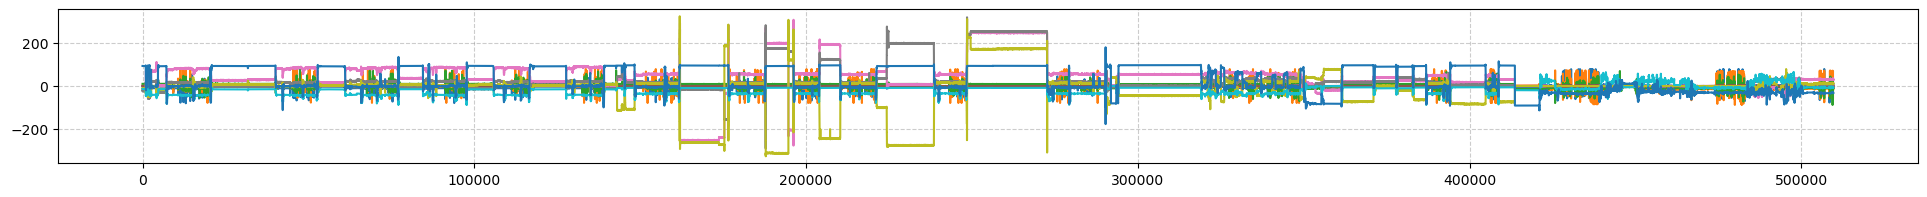

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("D:\\DataSet\\time_series\\archive\\TimeSeries.csv")
plt.figure(figsize = (24, 2))
for col in df.columns:
  plt.plot(df[col])
plt.grid(color="gray", linestyle = "--", alpha = .4)
plt.show()

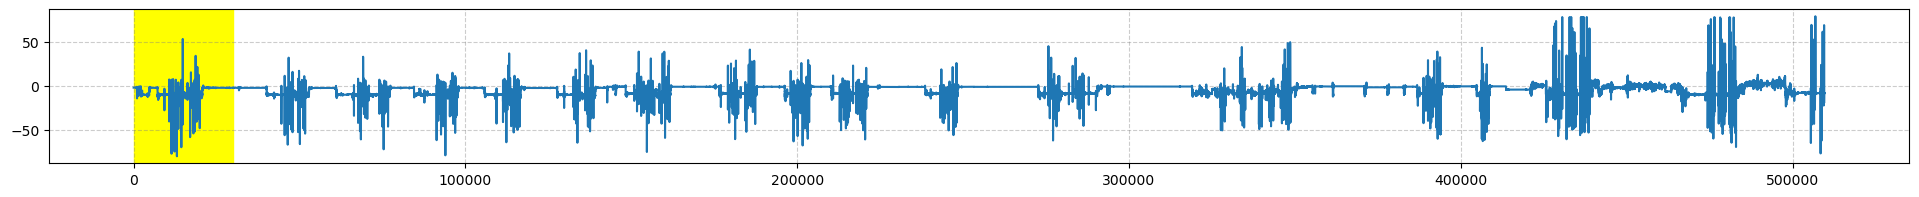

In [4]:
plt.figure(figsize = (24, 2))
for col in df.columns:
  plt.plot(df[col])
  break
plt.axvspan(0, 30000, color = "yellow")
plt.grid(color="gray", linestyle = "--", alpha = .4)
plt.show()

In [5]:
win_size = 1440
if __name__ == "__main__":
  x = df.to_numpy()[:df.shape[0]//2, 0]
  tr_data = list()
  for i in range(win_size, len(x)):
    tr_data.append(x[i-win_size:i])
  x = np.array(tr_data)
  model = SR_CNN_Model(window_size=64)
  model.fit(x, n_epochs=100)

Generating training data (Saliency Maps + Anomaly Injection)...
Starting training for 100 epochs...
Epoch [1/100], Loss: 0.6833
Epoch [2/100], Loss: 0.6497
Epoch [3/100], Loss: 0.6110
Epoch [4/100], Loss: 0.5762
Epoch [5/100], Loss: 0.5483
Epoch [6/100], Loss: 0.5265
Epoch [7/100], Loss: 0.5121
Epoch [8/100], Loss: 0.5033
Epoch [9/100], Loss: 0.4975
Epoch [10/100], Loss: 0.4944
Epoch [11/100], Loss: 0.4906
Epoch [12/100], Loss: 0.4896
Epoch [13/100], Loss: 0.4887
Epoch [14/100], Loss: 0.4878
Epoch [15/100], Loss: 0.4857
Epoch [16/100], Loss: 0.4854
Epoch [17/100], Loss: 0.4851
Epoch [18/100], Loss: 0.4851
Epoch [19/100], Loss: 0.4846
Epoch [20/100], Loss: 0.4842
Epoch [21/100], Loss: 0.4832
Epoch [22/100], Loss: 0.4842
Epoch [23/100], Loss: 0.4850
Epoch [24/100], Loss: 0.4824
Epoch [25/100], Loss: 0.4821
Epoch [26/100], Loss: 0.4834
Epoch [27/100], Loss: 0.4822
Epoch [28/100], Loss: 0.4812
Epoch [29/100], Loss: 0.4827
Epoch [30/100], Loss: 0.4828
Epoch [31/100], Loss: 0.4812
Epoch [32/

In [ ]:
# Inference
test = df.to_numpy()[:5000, 0]
ts_data = list()
for i in range(win_size, len(test)):
  ts_data.append(test[i-win_size:i])
test = np.array(ts_data)

scores = model(test)
map = model.generate_saliency_map(test)
arr = df.to_numpy()[:5000, 0]
fig, ax = plt.subplots(2, 1, figsize = (24, 4), sharex=True)
ax[0].plot(arr)
ax[1].plot(np.arange(len(arr)-len(scores), len(arr)), scores, color = "red")
ax[0].grid(color="gray", alpha=.4, linestyle="--")
ax[1].grid(color="gray", alpha=.4, linestyle="--")
plt.show()

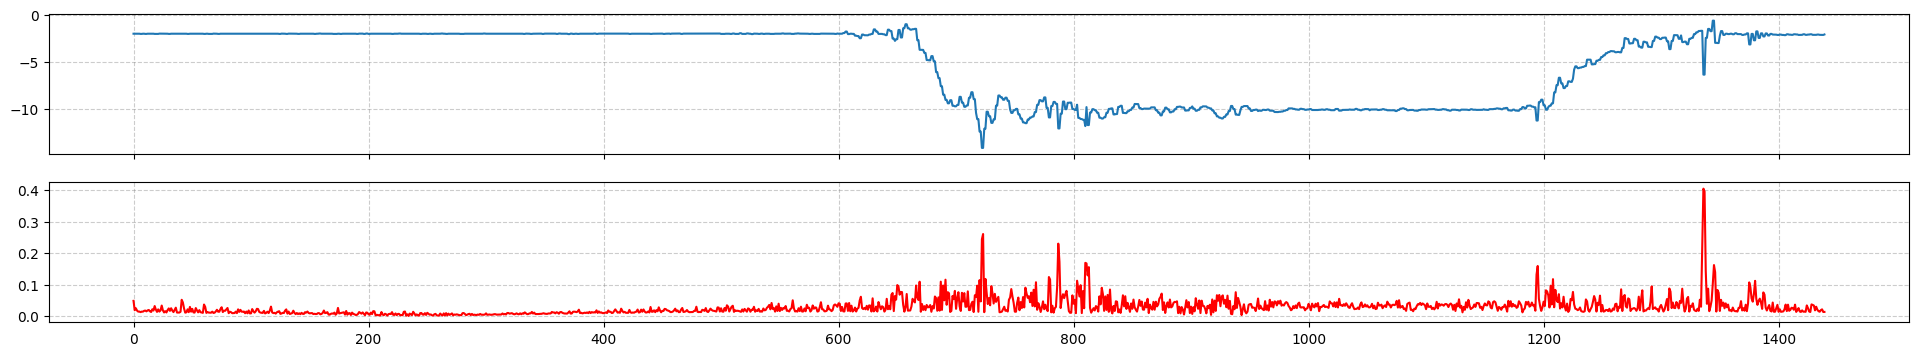

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (24, 4), sharex=True)
ax[0].plot(test[300, :])
ax[1].plot(map[300, :], color = "red")
ax[0].grid(color="gray", alpha=.4, linestyle="--")
ax[1].grid(color="gray", alpha=.4, linestyle="--")
plt.show()

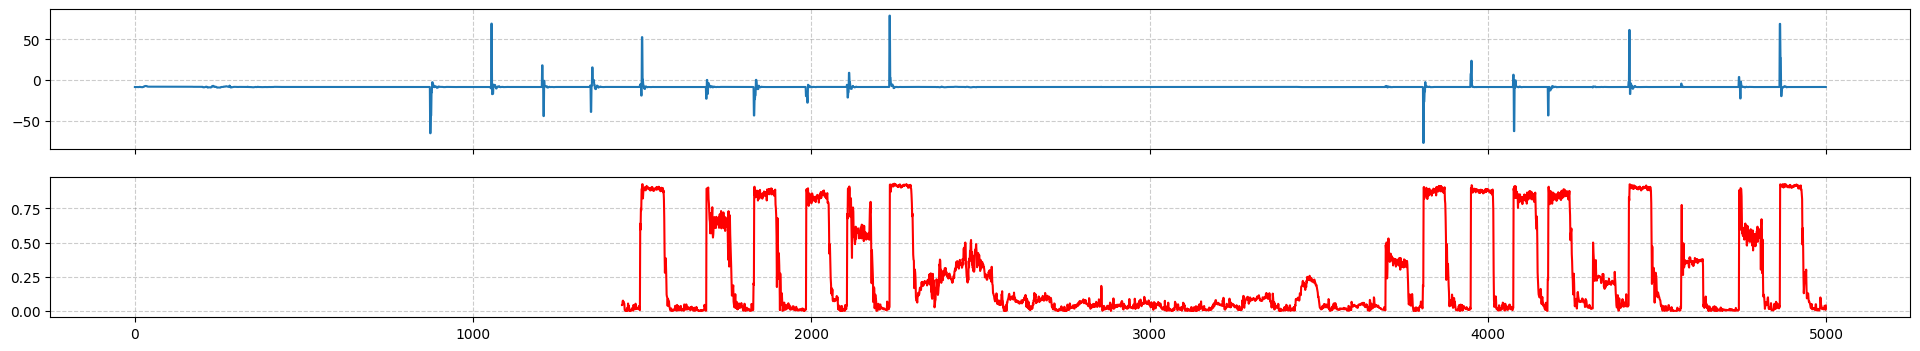

In [ ]:
# Inference
test = df.to_numpy()[-5000:, 0]
ts_data = list()
for i in range(win_size, len(test)):
  ts_data.append(test[i-win_size:i])
test = np.array(ts_data)

scores = model(test)
map = model.generate_saliency_map(test)
arr = df.to_numpy()[-5000:, 0]
fig, ax = plt.subplots(2, 1, figsize = (24, 4), sharex=True)
ax[0].plot(arr)
ax[1].plot(np.arange(len(arr)-len(scores), len(arr)), scores, color = "red")
ax[0].grid(color="gray", alpha=.4, linestyle="--")
ax[1].grid(color="gray", alpha=.4, linestyle="--")
plt.show()

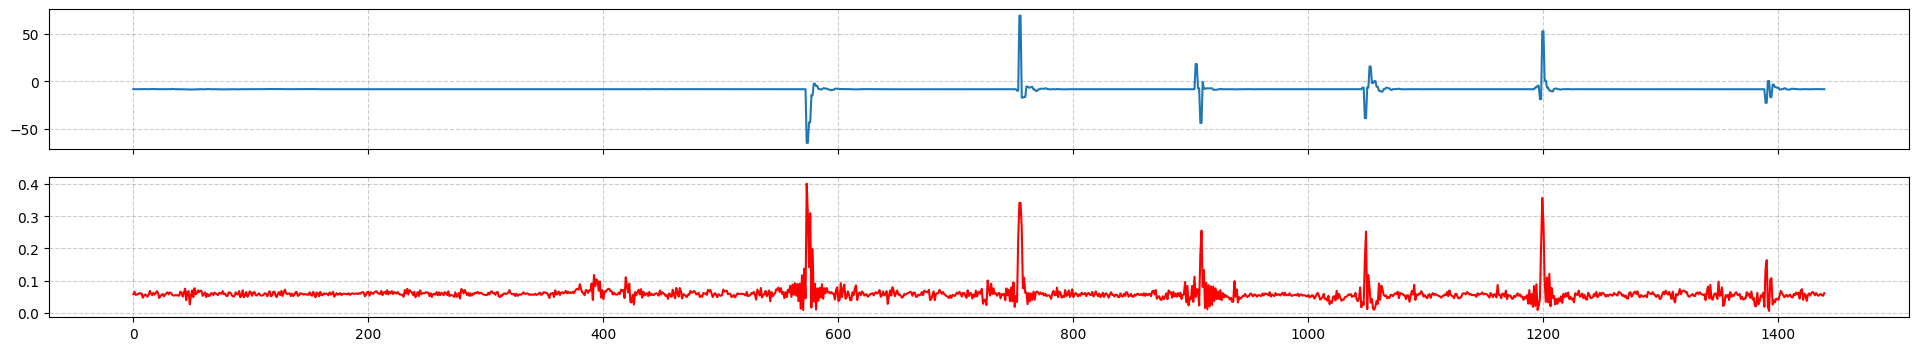

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (24, 4), sharex=True)
ax[0].plot(test[300, :])
ax[1].plot(map[300, :], color = "red")
ax[0].grid(color="gray", alpha=.4, linestyle="--")
ax[1].grid(color="gray", alpha=.4, linestyle="--")
plt.show()